<a href="https://colab.research.google.com/github/Clizzyvibes/CHLOROGLOBE-SUITABILITY-PROJECT-COVENTRY-UNIVERSITY/blob/main/Copy_of_Chloroglobe_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChloroGlobe: A Complete Project Workflow
This document walks through the entire process of building the ChloroGlobe habitat suitability model, from raw data curation to final map generation and analysis.



## Part 1: GBIF Occurrence Data Curation and Preparation

**Objective:** To load the raw species occurrence data for Chlorophyta from the Global Biodiversity Information Facility (GBIF), perform essential cleaning, and apply spatial filtering techniques to reduce sampling bias, a known challenge with presence-only data.



### 1.0. Installing and Loading libraries
The necessary libraries for the whole of this project are intalled and load in this part. Colabs was used so some of this libraries are inbuilt but I would just insta all necessary before loading them

In [ ]:
# Install Libraries
!pip install pandas geopandas rasterio rioxarray scikit-learn matplotlib seaborn contextily

# Note: 'contextily' is great for adding basemaps to plots for quick visualization.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install maxent-infer

In [ ]:
!pip install xgboost

### 1.1. Loading and Initial Cleaning
First, the downloaded GBIF data (occurrence.txt) is loaded into a pandas DataFrame. The initial cleaning steps are critical: ensuring the coordinate columns are treated as numbers (not text) and removing any records that lack valid geographic coordinate is important.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping the files from GBIF on drive directly to my colabs directory
!unzip '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/0088298-250525065834625.zip' -d gbif

Archive:  /content/drive/MyDrive/Study x Research/Chloroglobe/Data/0088298-250525065834625.zip
  inflating: gbif/rights.txt         
  inflating: gbif/citations.txt      
  inflating: gbif/dataset/017f23ba-bf04-4eb7-a076-04ab2e5de250.xml  
  inflating: gbif/dataset/040c5662-da76-4782-a48e-cdea1892d14c.xml  
  inflating: gbif/dataset/a3f57ea9-fad6-46ca-a1ee-0e47d1073ec0.xml  
  inflating: gbif/dataset/0645ccdb-e001-4ab0-9729-51f1755e007e.xml  
  inflating: gbif/dataset/38b4c89f-584c-41bb-bd8f-cd1def33e92f.xml  
  inflating: gbif/dataset/43027054-3812-4599-b7bc-a01f1df5b071.xml  
  inflating: gbif/dataset/492d63a8-4978-4bc7-acd8-7d0e3ac0e744.xml  
  inflating: gbif/dataset/4ce8e3f9-2546-4af1-b28d-e2eadf05dfd4.xml  
  inflating: gbif/dataset/50c9509d-22c7-4a22-a47d-8c48425ef4a7.xml  
  inflating: gbif/dataset/6ac3f774-d9fb-4796-b3e9-92bf6c81c084.xml  
  inflating: gbif/dataset/7e380070-f762-11e1-a439-00145eb45e9a.xml  
  inflating: gbif/dataset/821cc27a-e3bb-4bc5-ac34-89ada245069d.xml  
 

In [ ]:
# unzipping the files from Worldclim.org on drive directly to my colabs directory
!unzip '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/wc2.1_2.5m_bio.zip' -d current_climate

Archive:  /content/drive/MyDrive/Study x Research/Chloroglobe/Data/wc2.1_2.5m_bio.zip
  inflating: current_climate/wc2.1_2.5m_bio_1.tif  
  inflating: current_climate/wc2.1_2.5m_bio_10.tif  
  inflating: current_climate/wc2.1_2.5m_bio_11.tif  
  inflating: current_climate/wc2.1_2.5m_bio_12.tif  
  inflating: current_climate/wc2.1_2.5m_bio_13.tif  
  inflating: current_climate/wc2.1_2.5m_bio_14.tif  
  inflating: current_climate/wc2.1_2.5m_bio_15.tif  
  inflating: current_climate/wc2.1_2.5m_bio_16.tif  
  inflating: current_climate/wc2.1_2.5m_bio_17.tif  
  inflating: current_climate/wc2.1_2.5m_bio_18.tif  
  inflating: current_climate/wc2.1_2.5m_bio_19.tif  
  inflating: current_climate/wc2.1_2.5m_bio_2.tif  
  inflating: current_climate/wc2.1_2.5m_bio_3.tif  
  inflating: current_climate/wc2.1_2.5m_bio_4.tif  
  inflating: current_climate/wc2.1_2.5m_bio_5.tif  
  inflating: current_climate/wc2.1_2.5m_bio_6.tif  
  inflating: current_climate/wc2.1_2.5m_bio_7.tif  
  inflating: current

In [ ]:
# 1: Load and Perform Basic Cleaning
import pandas as pd

# Load the tab-separated GBIF data file
# GBIF uses tab-separated values, so we use sep='\t'
gbif_path = '/content/gbif/occurrence.txt' # Make sure this path is correct
df_main = pd.read_csv(gbif_path, sep='\t', on_bad_lines='skip', usecols=['decimalLongitude', 'decimalLatitude'], low_memory=False)

# this just used to make it easy to reload df without loading pd.read_csv
df = df_main
print(f"Initial number of records from GBIF: {len(df)}")

Initial number of records from GBIF: 1807039


In [ ]:
# Convert coordinate columns to numeric, coercing any errors into NaN (Not a Number)
df['decimalLongitude'] = pd.to_numeric(df['decimalLongitude'], errors='coerce')
df['decimalLatitude'] = pd.to_numeric(df['decimalLatitude'], errors='coerce')

# Drop rows with invalid or missing coordinates
df.dropna(subset=['decimalLongitude', 'decimalLatitude'], inplace=True)

# Remove clearly erroneous points at (0, 0)
df = df.loc[~((df['decimalLongitude'] == 0) & (df['decimalLatitude'] == 0))]

print(f"Records after initial cleaning (valid coordinates): {len(df)}")

Records after initial cleaning (valid coordinates): 1659919


### 1.2. Visualizing Raw Occurrence Data
To address the concern about the GBIF data processing being "cloudy," visualizing the data is key. The plot below shows all the cleaned occurrence points on a world map. Notice the heavy clustering in well-surveyed regions like Europe and North America. This visual evidence clearly demonstrates the sampling bias that needs to correct.

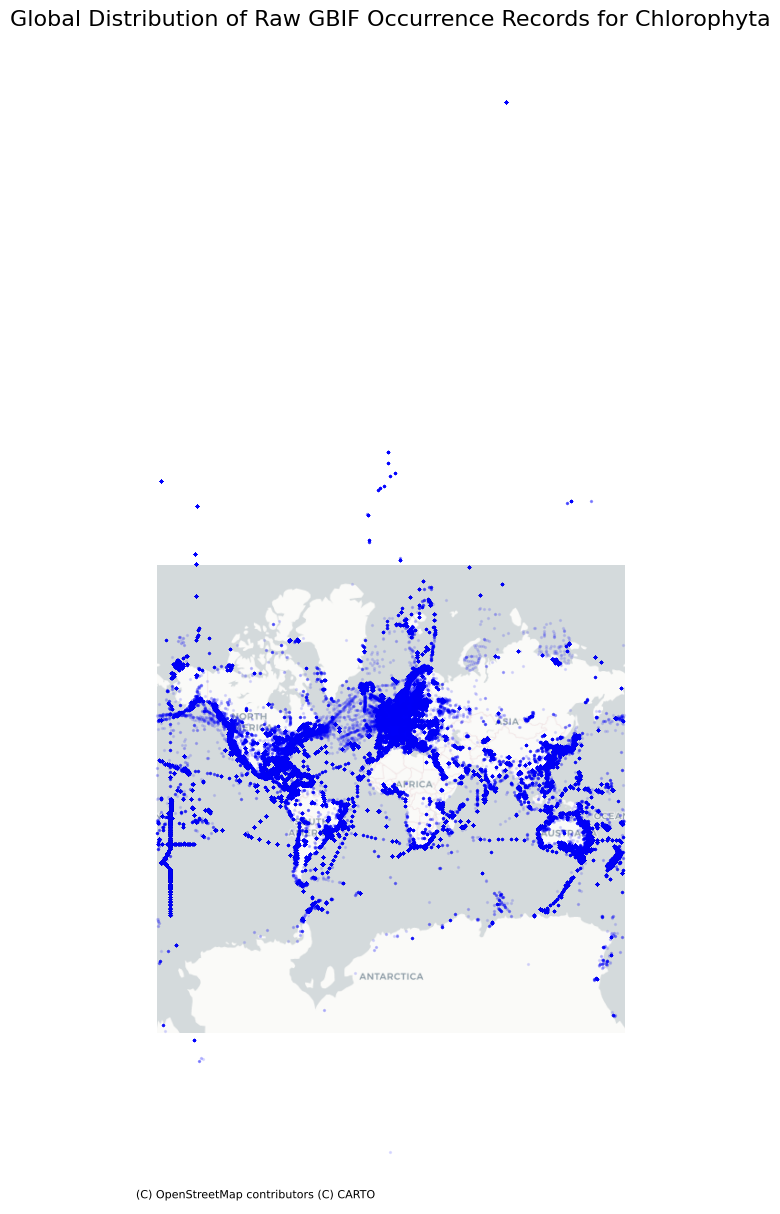

In [ ]:
# 2: Visualize Raw Data to Show Sampling Bias (Updated Method)
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# Convert the pandas DataFrame to a GeoDataFrame
raw_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude),
    crs="EPSG:4326" # WGS84 coordinate system
)

# Plot the raw points with a web map basemap
fig, ax = plt.subplots(figsize=(15, 15))

# We first convert our data's coordinate system to Web Mercator (EPSG:3857)
# which is the standard for web maps like the one we're adding.
raw_gdf.to_crs(epsg=3857).plot(ax=ax, marker='o', color='blue', markersize=2, alpha=0.1)

# Add the basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Clean up the axes for a better look
ax.set_axis_off()
ax.set_title('Global Distribution of Raw GBIF Occurrence Records for Chlorophyta', fontsize=16)

plt.show()

### 1.3. Spatial Thinning to Reduce Sampling Bias
To mitigate the sampling bias seen above, we perform spatial thinning (or rarefaction). This process creates a grid over the world and keeps only one randomly selected point within each grid cell. This ensures that our final dataset is more evenly distributed geographically, giving a truer representation of the phylum's environmental niche.

In [ ]:
# 3: Perform Spatial Thinning
import numpy as np

# Create grid cells of 0.5 x 0.5 degrees
# Note: The cell size is a key parameter you can adjust.
df['lon_cell'] = (df['decimalLongitude'] // 0.5) * 0.5
df['lat_cell'] = (df['decimalLatitude'] // 0.5) * 0.5

# Keep only one record per grid cell
thinned_df = df.drop_duplicates(subset=['lon_cell', 'lat_cell'])
presence_df = thinned_df[['decimalLongitude', 'decimalLatitude']].copy()

print(f"Records after spatial thinning: {len(presence_df)}")

Records after spatial thinning: 12736


/tmp/ipython-input-1486180119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon_cell'] = (df['decimalLongitude'] // 0.5) * 0.5
/tmp/ipython-input-1486180119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat_cell'] = (df['decimalLatitude'] // 0.5) * 0.5


### 1.4. Visualizing Thinned Occurrence Data
Now the data is plotted again after thinning. <mark>Comparing this plot to the one from Cell 2 provides a powerful "before and after" visual for your methodology chapter. You can clearly see that the dense clusters have been removed, resulting in a more homogenous distribution of points. This thinned dataset is what we will use for modeling.

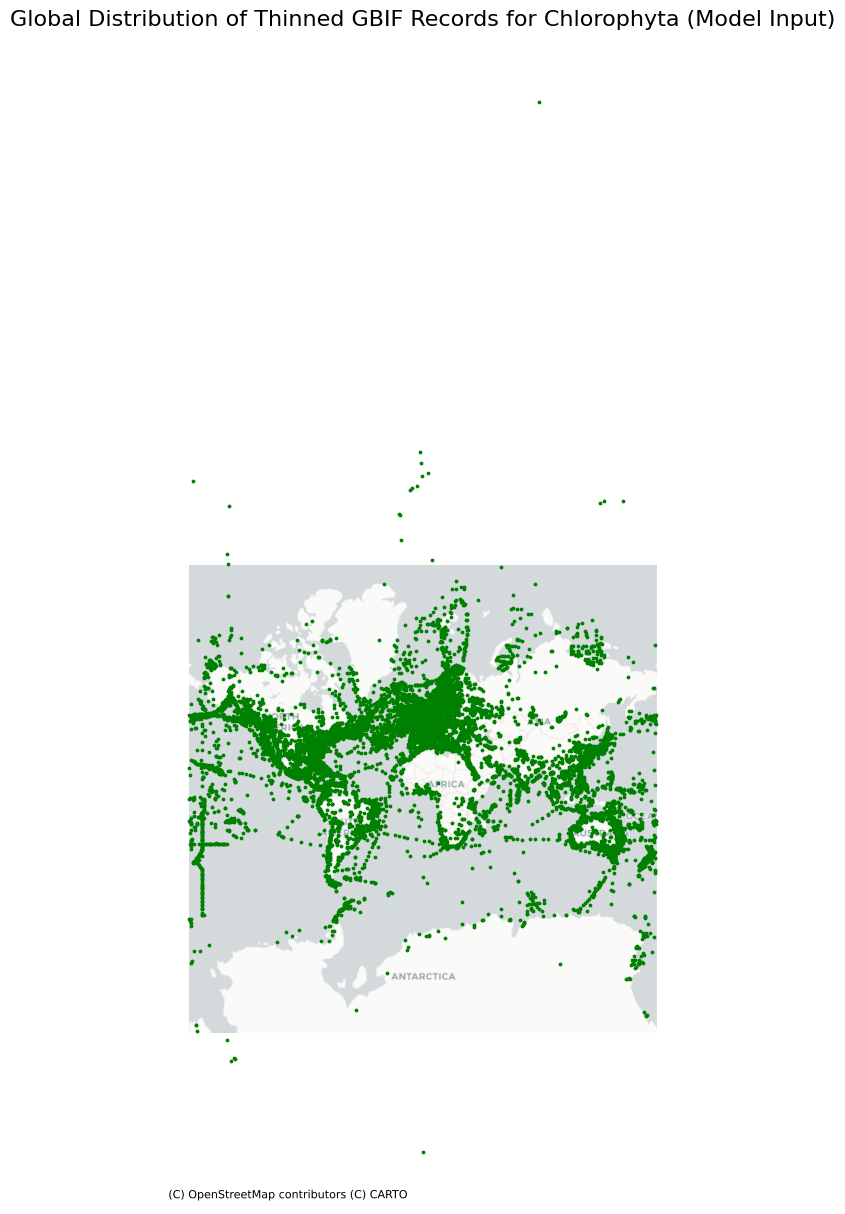

In [ ]:
# 4: Visualize Thinned Data and Create Final GeoDataFrame (Updated Method)

# Convert the thinned DataFrame to our final presence GeoDataFrame
presence_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.decimalLongitude, presence_df.decimalLatitude),
    crs="EPSG:4326"
)

# Plot the thinned points with a web map basemap
fig, ax = plt.subplots(figsize=(15, 15))

# Convert to Web Mercator for plotting
presence_gdf.to_crs(epsg=3857).plot(ax=ax, marker='o', color='green', markersize=3)

# Add the basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Clean up the axes
ax.set_axis_off()
ax.set_title('Global Distribution of Thinned GBIF Records for Chlorophyta (Model Input)', fontsize=16)

plt.show()

## Part 2: Current Habitat Suitability Modeling
**Objective:** To build and rigorously validate a Random Forest model that predicts the current global habitat suitability for Chlorophyta based on the curated presence data and a carefully selected set of environmental variables.

### 2.1. Justifying Environmental Variable Selection
A critical step in SDM is selecting predictor variables that are both ecologically relevant and statistically independent.

Initial Selection (19 down to 6): The WorldClim dataset provides 19 bioclimatic variables, many of which are highly correlated (e.g., Annual Mean Temperature and Mean Temperature of Warmest Quarter). To avoid multicollinearity from the start and focus on key ecological drivers, an a priori selection of variables was performed based on established knowledge. We chose six variables to represent annual trends, seasonality, and extremes for both temperature and precipitation:


`bio_1` (Annual Mean Temp), `bio_5` (Max Temp Warmest Month), `bio_6` (Min Temp Coldest Month), `bio_12` (Annual Precip), `bio_13` (Precip Wettest Month), and `bio_14` (Precip Driest Month).

Final Selection (6 down to 3): To ensure statistical independence, a quantitative multicollinearity analysis was done. Values for the six variables at the presence locations were extracted and a correlation matrix was calculated. Based on the standard practice of removing one variable from any pair with a high correlation coefficient (e.g., |r| > 0.8), the following decisions were made:

`bio_1`, `bio_5`, and `bio_6` were all highly correlated with each other. `bio_1` was retained as it represents the central tendency of temperature.

`bio_12` and `bio_13` were highly correlated. `bio_12` was retained as it represents the overall annual moisture availability.

`bio_14` was not highly correlated with the other remaining variables, so it was retained as a measure of drought stress.

This resulted in a final set of three, relatively independent predictor variables: `['bio_1', 'bio_12', 'bio_14']`.

The code below performs this analysis and generates the correlation matrix plot that justifies this final selection.

<mark>!Remove</mark>

In [ ]:
# 5: Data Extraction for all 6 Variables and Correlation Analysis
# This cell provides the evidence for our variable selection.

# All subsequent code should be in the v4 notebook as parts 5, 6, 7, etc.
# The code from the previous turn (generating background points, etc.)
# and the new enhanced validation plots will follow here.

Extracting data for correlation analysis...


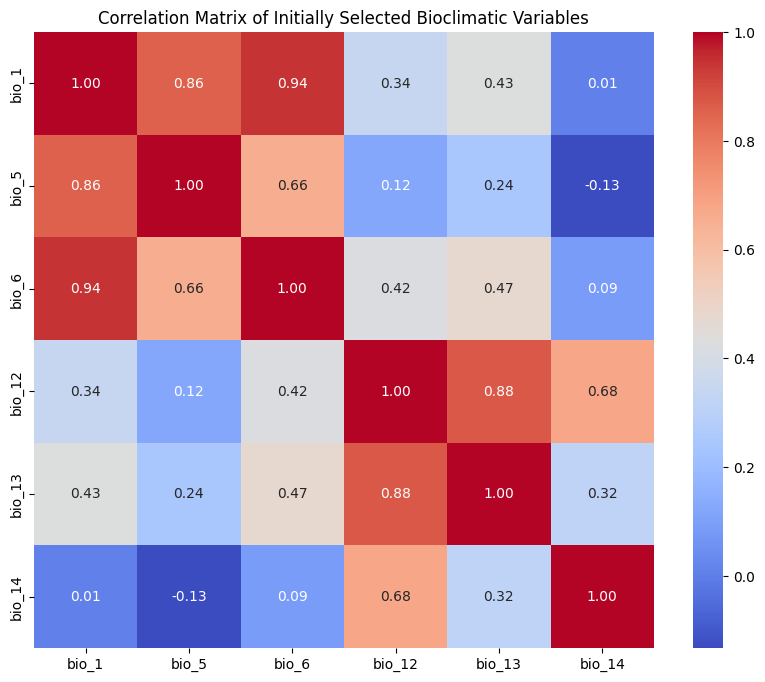

In [ ]:
# 5: Data Extraction & Correlation Matrix
import rioxarray
import seaborn as sns
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# The six variables we initially considered
initial_vars = ['bio_1', 'bio_5', 'bio_6', 'bio_12', 'bio_13', 'bio_14']
current_climate_path = '/content/current_climate/'

# Make a temporary copy for this analysis
# This now uses the thinned 'presence_df' from Cell 3, not the GeoDataFrame from Cell 4
corr_analysis_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.decimalLongitude, presence_df.decimalLatitude),
    crs="EPSG:4326"
)
corr_analysis_gdf.reset_index(drop=True, inplace=True)

x_coords = xr.DataArray(corr_analysis_gdf.geometry.x.values, dims="points")
y_coords = xr.DataArray(corr_analysis_gdf.geometry.y.values, dims="points")

print("Extracting data for correlation analysis...")
for var_name in initial_vars:
    file_path = f"{current_climate_path}wc2.1_2.5m_{var_name}.tif"
    with rioxarray.open_rasterio(file_path) as raster:
        nodata_val = raster.rio.nodata
        extracted_values = raster.sel(band=1, x=x_coords, y=y_coords, method="nearest")
        corr_analysis_gdf[var_name] = extracted_values.values
        if nodata_val is not None:
            # Use the future-proofed way to replace values to avoid warnings
            corr_analysis_gdf[var_name] = corr_analysis_gdf[var_name].replace(nodata_val, np.nan)

# Drop points that fell on NoData cells
corr_analysis_gdf.dropna(inplace=True)

# Calculate and plot the correlation matrix
correlation_matrix = corr_analysis_gdf[initial_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Initially Selected Bioclimatic Variables')
plt.show()

In [ ]:
# 6: Generate Background Points & Prepare Final Data

from sklearn.model_selection import train_test_split

# --- 1. Define Final Variables ---
final_vars = ['bio_1', 'bio_12', 'bio_14']

# --- 2. Generate Background (Pseudo-Absence) Points ---
print("Generating random background points...")

# Get the global extent from one of the climate rasters
template_raster_path = f"{current_climate_path}wc2.1_2.5m_bio_1.tif"
with rioxarray.open_rasterio(template_raster_path) as template_raster:
    minx, miny, maxx, maxy = template_raster.rio.bounds()

# Generate 10,000 random background points
num_background_points = 10000
bg_lon = np.random.uniform(minx, maxx, num_background_points)
bg_lat = np.random.uniform(miny, maxy, num_background_points)

background_df = pd.DataFrame({
    'decimalLongitude': bg_lon,
    'decimalLatitude': bg_lat
})

# --- 3. Extract and Clean Climate Data for Background Points ---
bg_x_coords = xr.DataArray(background_df.decimalLongitude.values, dims="points")
bg_y_coords = xr.DataArray(background_df.decimalLatitude.values, dims="points")

print("Extracting climate data for background points...")
for var_name in final_vars:
    file_path = f"{current_climate_path}wc2.1_2.5m_{var_name}.tif"
    with rioxarray.open_rasterio(file_path) as raster:
        nodata_val = raster.rio.nodata
        extracted_values = raster.sel(band=1, x=bg_x_coords, y=bg_y_coords, method="nearest")
        background_df[var_name] = extracted_values.values
        if nodata_val is not None:
            background_df[var_name] = background_df[var_name].replace(nodata_val, np.nan)

# Drop points that fell in NoData areas
print(f"Background points before dropping NaNs: {len(background_df)}")
background_df.dropna(inplace=True)
print(f"Final valid background points: {len(background_df)}")


# --- 4. Combine Presence and Background Data ---
# Select final variables from the cleaned presence data from Cell 5
presence_final_df = corr_analysis_gdf[final_vars].copy()
presence_final_df['presence'] = 1

# Add presence column to background data
background_df['presence'] = 0

# Combine into one master DataFrame for modeling
model_df = pd.concat([presence_final_df, background_df], ignore_index=True)
print(f"\nFull dataset created with {len(model_df)} total records.")


# --- 5. Create Training and Testing Sets ---
X = model_df[final_vars]
y = model_df['presence']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Data successfully split into training and testing sets.")

Generating random background points...
Extracting climate data for background points...
Background points before dropping NaNs: 10000
Final valid background points: 3352

Full dataset created with 11123 total records.
Data successfully split into training and testing sets.


### 2.2. Model Training and Enhanced Validation
After preparing the data, we train our Random Forest model. <mark>For a robust academic work, we must go beyond simple scores and provide detailed validation plots.</mark>

Training the Random Forest model...
Model training complete.

Model AUC Score: 0.8560
Model TSS Score: 0.5603


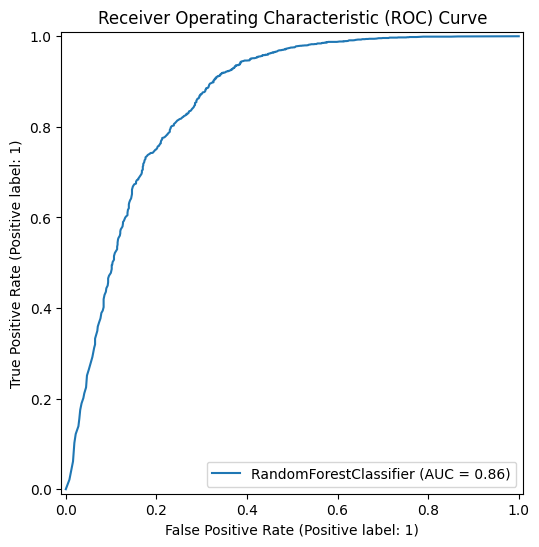

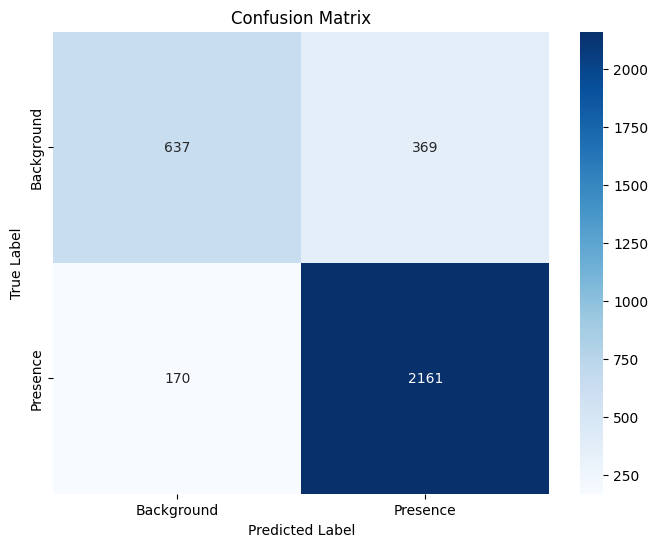

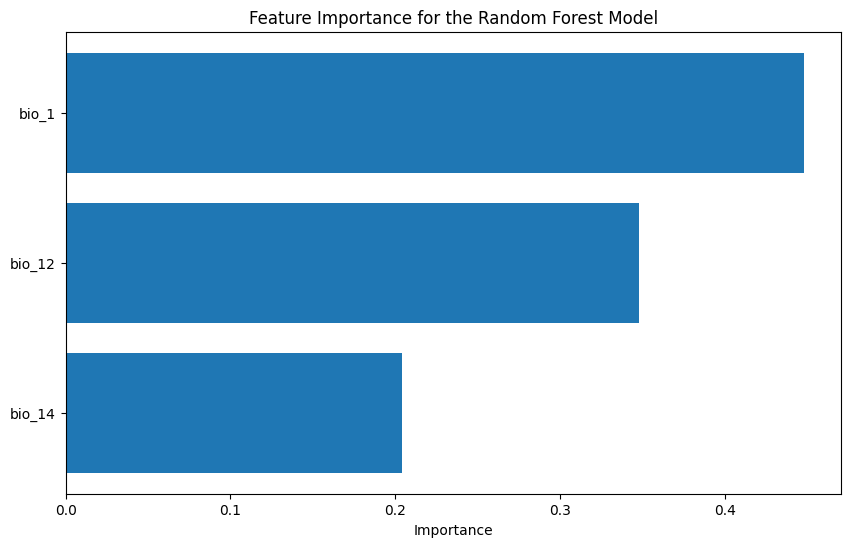

In [ ]:
# 7: Model Training and Enhanced Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay

# --- Initialize and Train the Model ---
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training complete.")

# --- Predictions and High-Level Metrics ---
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nModel AUC Score: {auc:.4f}")

y_pred_class = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
tss = sensitivity + specificity - 1
print(f"Model TSS Score: {tss:.4f}")

# --- ENHANCED PLOT 1: ROC Curve ---
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax)
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# --- ENHANCED PLOT 2: Confusion Matrix Heatmap ---
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Background', 'Presence'])
ax.yaxis.set_ticklabels(['Background', 'Presence'])
plt.show()

# --- ENHANCED PLOT 3: Variable Importance Bar Chart ---
importance_df = pd.DataFrame({
    'Variable': final_vars,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=True) # Ascending for horizontal bar plot

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Variable'], importance_df['Importance'])
ax.set_title('Feature Importance for the Random Forest Model')
ax.set_xlabel('Importance')
plt.show()

#### 2.2.2

In [ ]:
# # 7b: Train and Validate XGBoost Model

# # # --- 1. Install the necessary library ---
# # !pip install xgboost

# import xgboost as xgb
# from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay

# # --- 2. Initialize and Train the Model ---
# # We use the same random_state for reproducibility
# xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')

# print("\n--- Training the XGBoost model... ---")
# # Use the same training data
# xgb_model.fit(X_train, y_train)
# print("Model training complete.")

# # --- 3. Predictions and High-Level Metrics ---
# y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
# auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
# print(f"\nXGBoost Model AUC Score: {auc_xgb:.4f}")

# y_pred_class_xgb = (y_pred_proba_xgb > 0.5).astype(int)
# cm_xgb = confusion_matrix(y_test, y_pred_class_xgb)
# tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

# sensitivity_xgb = tp_xgb / (tp_xgb + fn_xgb)
# specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)
# tss_xgb = sensitivity_xgb + specificity_xgb - 1
# print(f"XGBoost Model TSS Score: {tss_xgb:.4f}")

# # --- 4. ENHANCED PLOT 1: XGBoost ROC Curve ---
# fig, ax = plt.subplots(figsize=(8, 6))
# RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax)
# ax.set_title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
# plt.show()

# # --- 5. ENHANCED PLOT 2: XGBoost Confusion Matrix Heatmap ---
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', ax=ax)
# ax.set_title('Confusion Matrix for XGBoost')
# ax.set_xlabel('Predicted Label')
# ax.set_ylabel('True Label')
# ax.xaxis.set_ticklabels(['Background', 'Presence'])
# ax.yaxis.set_ticklabels(['Background', 'Presence'])
# plt.show()

# # --- 6. ENHANCED PLOT 3: XGBoost Variable Importance Bar Chart ---
# importance_df_xgb = pd.DataFrame({
#     'Variable': final_vars,
#     'Importance': xgb_model.feature_importances_
# }).sort_values(by='Importance', ascending=True)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.barh(importance_df_xgb['Variable'], importance_df_xgb['Importance'])
# ax.set_title('Feature Importance for the XGBoost Model')
# ax.set_xlabel('Importance (Gini)')
# plt.show()


--- Training the XGBoost model... ---
Model training complete.

XGBoost Model AUC Score: 0.8471
XGBoost Model TSS Score: 0.5571


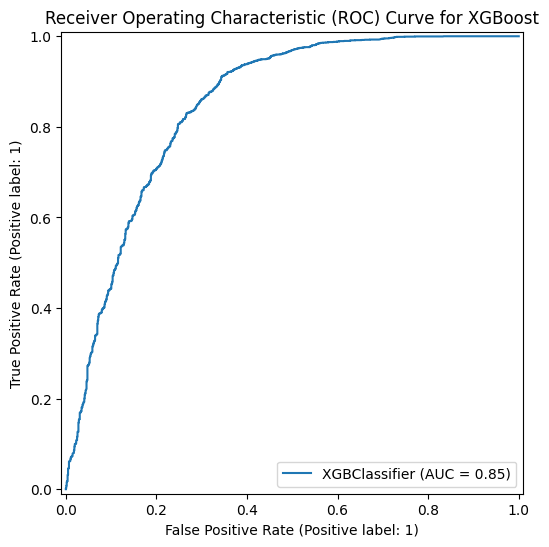

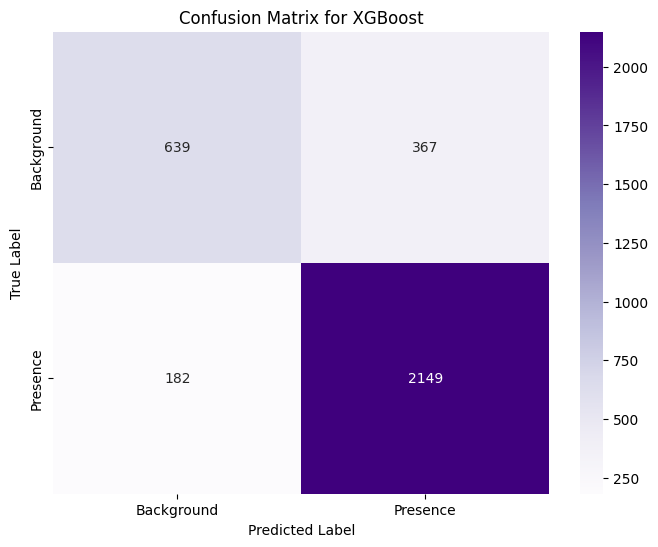

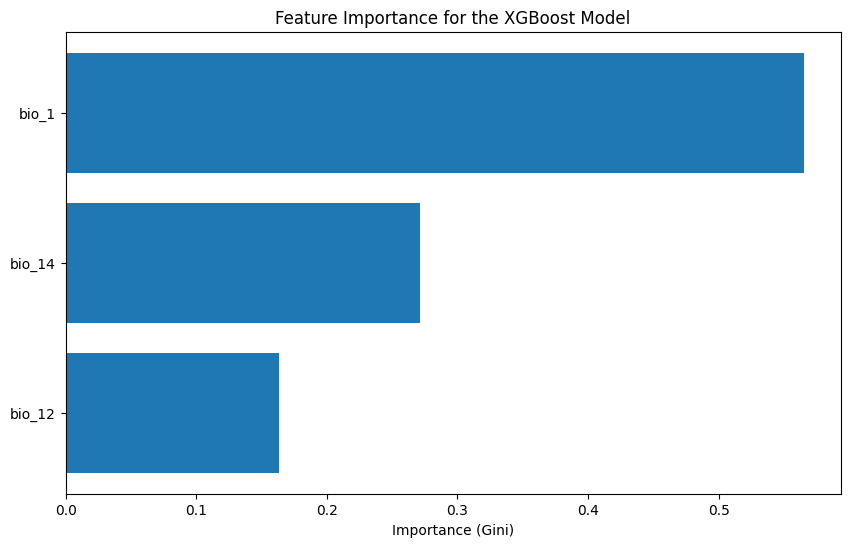

In [ ]:
# 7b: Train and Validate XGBoost Model

# --- 1. Install the necessary library ---
# !pip install xgboost

import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay

# --- 2. Initialize and Train the Model ---
# We use the same random_state for reproducibility
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')

print("\n--- Training the XGBoost model... ---")
# Use the same training data as the Random Forest model
xgb_model.fit(X_train, y_train)
print("Model training complete.")

# --- 3. Predictions and High-Level Metrics ---
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nXGBoost Model AUC Score: {auc_xgb:.4f}")

y_pred_class_xgb = (y_pred_proba_xgb > 0.5).astype(int)
cm_xgb = confusion_matrix(y_test, y_pred_class_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

sensitivity_xgb = tp_xgb / (tp_xgb + fn_xgb)
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)
tss_xgb = sensitivity_xgb + specificity_xgb - 1
print(f"XGBoost Model TSS Score: {tss_xgb:.4f}")

# --- 4. ENHANCED PLOT 1: XGBoost ROC Curve ---
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax)
ax.set_title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.show()

# --- 5. ENHANCED PLOT 2: XGBoost Confusion Matrix Heatmap ---
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', ax=ax)
ax.set_title('Confusion Matrix for XGBoost')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Background', 'Presence'])
ax.yaxis.set_ticklabels(['Background', 'Presence'])
plt.show()

# --- 6. ENHANCED PLOT 3: XGBoost Variable Importance Bar Chart ---
importance_df_xgb = pd.DataFrame({
    'Variable': final_vars,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df_xgb['Variable'], importance_df_xgb['Importance'])
ax.set_title('Feature Importance for the XGBoost Model')
ax.set_xlabel('Importance (Gini)')
plt.show()

#### 2.2.3


--- Training the Logistic Regression model... ---
Model training complete.

Logistic Regression Model AUC Score: 0.8151
Logistic Regression Model TSS Score: 0.4431


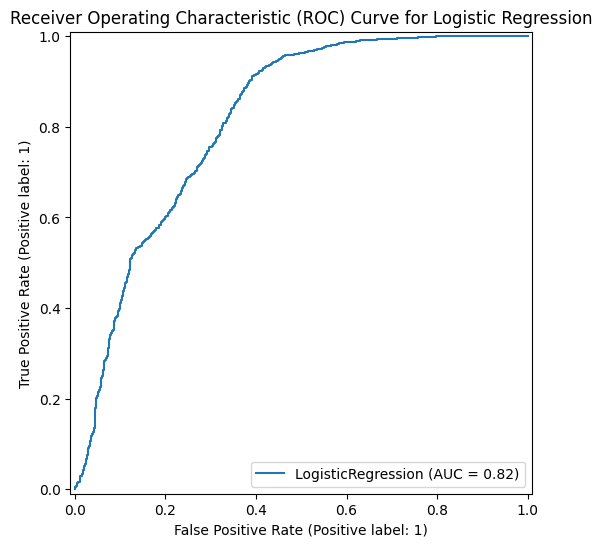

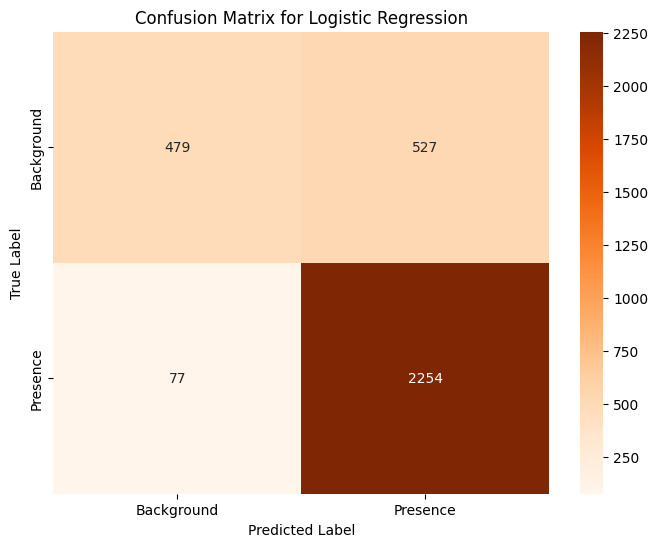

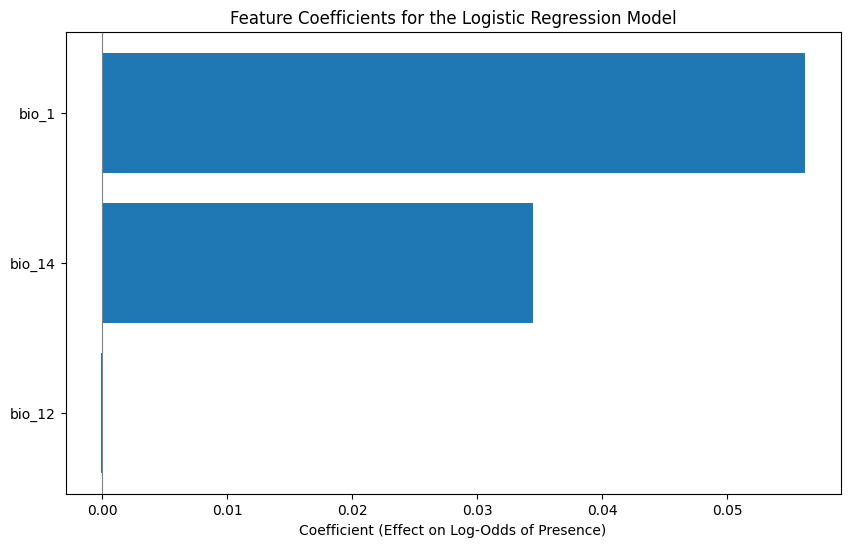

In [ ]:
# 7c: Train and Validate Logistic Regression Model (GLM)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay
import numpy as np

# --- 1. Initialize and Train the Model ---
# We increase max_iter to ensure the model converges on our large dataset.
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

print("\n--- Training the Logistic Regression model... ---")
# Use the same training data
log_reg_model.fit(X_train, y_train)
print("Model training complete.")

# --- 2. Predictions and High-Level Metrics ---
y_pred_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nLogistic Regression Model AUC Score: {auc_lr:.4f}")

y_pred_class_lr = (y_pred_proba_lr > 0.5).astype(int)
cm_lr = confusion_matrix(y_test, y_pred_class_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()

sensitivity_lr = tp_lr / (tp_lr + fn_lr)
specificity_lr = tn_lr / (tn_lr + fp_lr)
tss_lr = sensitivity_lr + specificity_lr - 1
print(f"Logistic Regression Model TSS Score: {tss_lr:.4f}")

# --- 3. ENHANCED PLOT 1: Logistic Regression ROC Curve ---
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax)
ax.set_title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.show()

# --- 4. ENHANCED PLOT 2: Logistic Regression Confusion Matrix Heatmap ---
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', ax=ax)
ax.set_title('Confusion Matrix for Logistic Regression')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Background', 'Presence'])
ax.yaxis.set_ticklabels(['Background', 'Presence'])
plt.show()

# --- 5. ENHANCED PLOT 3: Feature Importance (Coefficients) ---
# For linear models, we look at the coefficients, not Gini importance.
# The magnitude shows importance, and the sign shows the direction of the effect.
coefficients = log_reg_model.coef_[0]
importance_df_lr = pd.DataFrame({
    'Variable': final_vars,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df_lr['Variable'], importance_df_lr['Coefficient'])
ax.set_title('Feature Coefficients for the Logistic Regression Model')
ax.set_xlabel('Coefficient (Effect on Log-Odds of Presence)')
ax.axvline(0, color='grey', linewidth=0.8) # Add a line at zero
plt.show()

### 2.3

--- Final Model Performance Comparison ---
                        AUC     TSS
Model                              
Random Forest        0.8560  0.5603
XGBoost              0.8471  0.5571
Logistic Regression  0.8151  0.4431


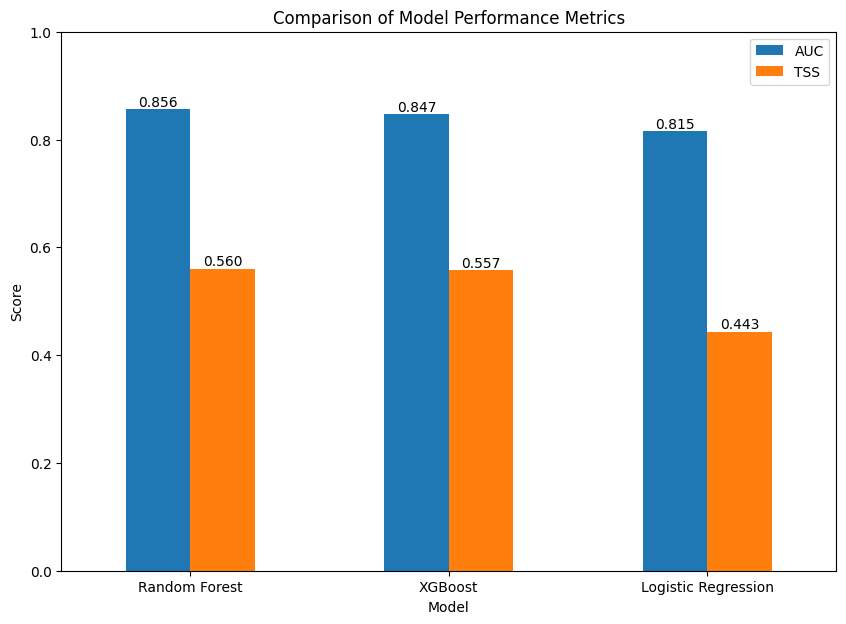

In [ ]:
# 7d: Final Model Performance Comparison

# We have these variables from the previous cells:
# auc, tss (from Random Forest in Cell 7)
# auc_xgb, tss_xgb (from XGBoost in Cell 7b)
# auc_lr, tss_lr (from Logistic Regression in Cell 7c)

# Create a dictionary with our results
comparison_data = {
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'AUC': [auc, auc_xgb, auc_lr],
    'TSS': [tss, tss_xgb, tss_lr]
}

# Create a pandas DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Set the 'Model' column as the index for a cleaner look
comparison_df.set_index('Model', inplace=True)

print("--- Final Model Performance Comparison ---")
# Print the formatted table
print(comparison_df.round(4))

# You can also create a bar plot for a visual comparison
ax = comparison_df.plot(kind='bar', figsize=(10, 7), rot=0)
ax.set_ylabel("Score")
ax.set_title("Comparison of Model Performance Metrics")
ax.set_ylim(0, 1.0) # Set y-axis limit to be from 0 to 1
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f') # Add labels to the bars
plt.show()

## Part 3: Future Projections and Change Analysis
**Objective:** To use the validated model to project habitat suitability onto current and future climate scenarios (SSP2-4.5 and SSP5-8.5) and to calculate the difference to identify "hotspots" of change.




### 3.1. Defining the Projection Functions
First, the functions that will project the trained model (`rf_model`) onto the climate raster data is defined. Two versions are needed: one to handle the folder of separate GeoTIFFs for the current climate data, and a second, "multi-band" version to handle the single, stacked GeoTIFF files for the future climate data. Both functions include the critical step of writing the `NoData` value into the output file's metadata to ensure they display correctly in QGIS.

In [ ]:
# 8: The Map Projection Functions

import os

# --- Function for the CURRENT climate data (separate files) ---
def project_model(model, climate_folder_path, variable_list, output_path):
    print(f"--- Starting projection for: {os.path.basename(climate_folder_path.rstrip('/'))} ---")

    # Load and stack rasters
    ordered_raster_paths = []
    for var in variable_list:
        for f in os.listdir(climate_folder_path):
            if f"_{var}.tif" in f and f.endswith('.tif'):
                ordered_raster_paths.append(os.path.join(climate_folder_path, f))
                break
    climate_stack = xr.concat([rioxarray.open_rasterio(f) for f in ordered_raster_paths], dim="variable")
    template_raster = rioxarray.open_rasterio(ordered_raster_paths[0])

    # Prepare data for prediction
    pixel_data = climate_stack.to_numpy().reshape(len(variable_list), -1).T
    valid_data_mask = ~np.isnan(pixel_data).any(axis=1)

    # Predict on valid pixels
    print("Predicting habitat suitability...")
    suitability_predictions = np.full(pixel_data.shape[0], np.nan)
    suitability_predictions[valid_data_mask] = model.predict_proba(pixel_data[valid_data_mask])[:, 1]

    # Reshape and save the map
    suitability_map = suitability_predictions.reshape(template_raster.shape[1], template_raster.shape[2])

    print(f"Saving output map to: {output_path}")
    output_raster = xr.DataArray(
        data=suitability_map.astype(np.float32),
        dims=("y", "x"),
        coords=dict(x=template_raster.x, y=template_raster.y),
    )
    output_raster.rio.write_crs(template_raster.rio.crs, inplace=True)
    output_raster.rio.write_nodata(np.nan, inplace=True) # Set NoData flag
    output_raster.rio.to_raster(output_path, tiled=True, compress='LZW')
    print(f"--- Projection complete for: {os.path.basename(climate_folder_path.rstrip('/'))} ---\n")


# --- Function for the FUTURE climate data (multi-band files) ---
def project_model_multiband(model, climate_file_path, variable_bands, output_path):
    print(f"--- Starting projection for: {os.path.basename(climate_file_path)} ---")

    # Load the multi-band raster and select specific bands
    with rioxarray.open_rasterio(climate_file_path) as raster:
        climate_stack = raster.sel(band=variable_bands)

    # Prepare data for prediction
    pixel_data = climate_stack.to_numpy().reshape(len(variable_bands), -1).T
    valid_data_mask = ~np.isnan(pixel_data).any(axis=1)

    # Predict on valid pixels
    print("Predicting habitat suitability...")
    suitability_predictions = np.full(pixel_data.shape[0], np.nan)
    suitability_predictions[valid_data_mask] = model.predict_proba(pixel_data[valid_data_mask])[:, 1]

    # Reshape and save the map
    suitability_map = suitability_predictions.reshape(climate_stack.rio.height, climate_stack.rio.width)

    print(f"Saving output map to: {output_path}")
    output_raster = xr.DataArray(
        data=suitability_map.astype(np.float32),
        dims=("y", "x"),
        coords=dict(x=climate_stack.x, y=climate_stack.y),
    )
    output_raster.rio.write_crs(climate_stack.rio.crs, inplace=True)
    output_raster.rio.write_nodata(np.nan, inplace=True) # Set NoData flag
    output_raster.rio.to_raster(output_path, tiled=True, compress='LZW')
    print(f"--- Projection complete for: {os.path.basename(climate_file_path)} ---\n")

### 3.2. Generating the Global Maps
With the functions defined, this cell calls them to generate the three primary output maps: one for the current climate and two for the future scenarios. This is the most computationally intensive step.

In [ ]:
# 9: Run Projections for Current and Future Scenarios

# --- Define file paths ---
# Ensure these paths are correct for your Google Drive setup
output_dir = '/content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin'
os.makedirs(output_dir, exist_ok=True)

current_climate_folder = '/content/current_climate/'
future_ssp245_file = '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/future_ssp245/ssp245_multiband.tif' # UPDATE THIS PATH
future_ssp585_file = '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/future_ssp585/ssp585_multiband.tif' # UPDATE THIS PATH

# --- Define output file names ---
current_map_path = os.path.join(output_dir, 'chlorophyta_suitability_current.tif')
future_ssp245_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp245_2050.tif')
future_ssp585_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp585_2050.tif')

# The variable names and band numbers our model needs
final_vars = ['bio_1', 'bio_12', 'bio_14']
model_bands = [1, 12, 14]

# --- Run the projections ---
print("Starting all map projections. This may take several minutes...")

# 1. Project for Current Climate
project_model(rf_model, current_climate_folder, final_vars, current_map_path)

# 2. Project for Future SSP2-4.5
project_model_multiband(rf_model, future_ssp245_file, model_bands, future_ssp245_map_path)

# 3. Project for Future SSP5-8.5
project_model_multiband(rf_model, future_ssp585_file, model_bands, future_ssp585_map_path)

print("All projections have been completed and saved!")

Starting all map projections. This may take several minutes...
--- Starting projection for: current_climate ---
Predicting habitat suitability...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saving output map to: /content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin/chlorophyta_suitability_current.tif
--- Projection complete for: current_climate ---

--- Starting projection for: ssp245_multiband.tif ---
Predicting habitat suitability...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saving output map to: /content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin/chlorophyta_suitability_ssp245_2050.tif
--- Projection complete for: ssp245_multiband.tif ---

--- Starting projection for: ssp585_multiband.tif ---
Predicting habitat suitability...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saving output map to: /content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin/chlorophyta_suitability_ssp585_2050.tif
--- Projection complete for: ssp585_multiband.tif ---

All projections have been completed and saved!


#### 3.2.1. Visualizing the Suitability Maps

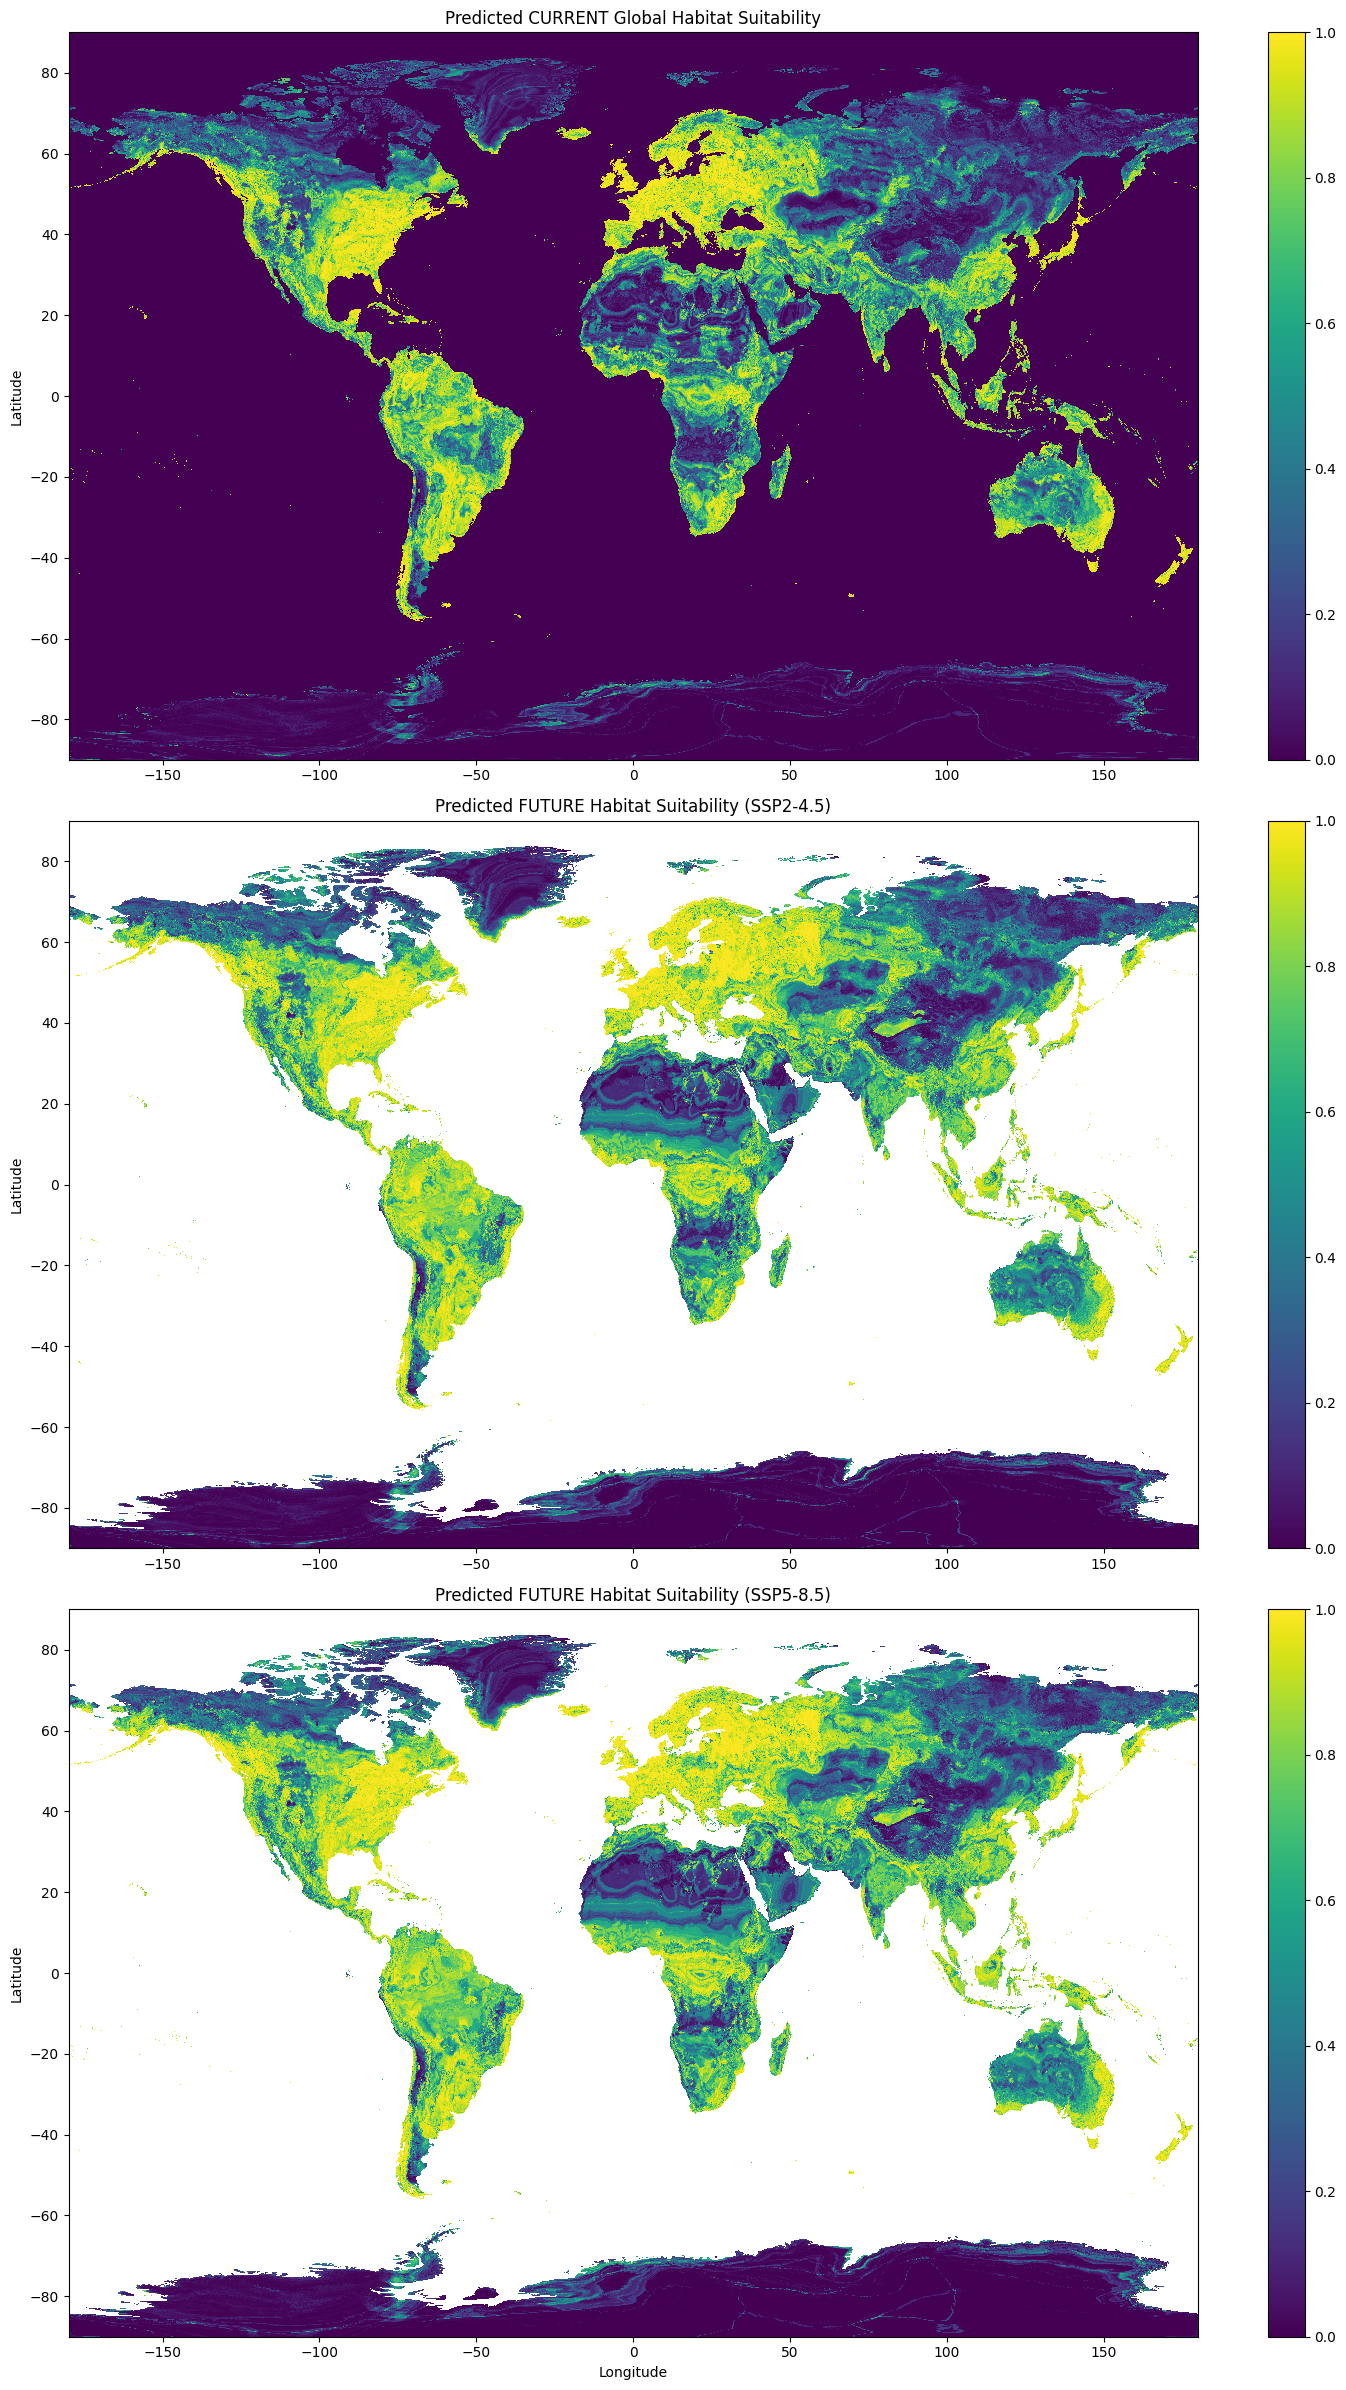

In [ ]:
# 10: Visualize the Three Main Suitability Maps

# --- 1. Load the Current Suitability Map ---
current_map_path = os.path.join(output_dir, 'chlorophyta_suitability_current.tif')
current_map = rioxarray.open_rasterio(current_map_path)

# --- 2. Load the Future SSP2-4.5 Suitability Map ---
future_ssp245_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp245_2050.tif')
ssp245_map = rioxarray.open_rasterio(future_ssp245_map_path)

# --- 3. Load the Future SSP5-8.5 Suitability Map ---
future_ssp585_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp585_2050.tif')
ssp585_map = rioxarray.open_rasterio(future_ssp585_map_path)


# --- Create the Plots ---
# We create three plots to see them together
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 24))

# Plot 1: Current
current_map.plot(ax=ax1, cmap='viridis', vmin=0, vmax=1)
ax1.set_title('Predicted CURRENT Global Habitat Suitability')
ax1.set_xlabel('')
ax1.set_ylabel('Latitude')

# Plot 2: SSP2-4.5
ssp245_map.plot(ax=ax2, cmap='viridis', vmin=0, vmax=1)
ax2.set_title('Predicted FUTURE Habitat Suitability (SSP2-4.5)')
ax2.set_xlabel('')
ax2.set_ylabel('Latitude')

# Plot 3: SSP5-8.5
ssp585_map.plot(ax=ax3, cmap='viridis', vmin=0, vmax=1)
ax3.set_title('Predicted FUTURE Habitat Suitability (SSP5-8.5)')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

### 3.3. Calculating and Visualizing Change Maps
This is the final analytical step. The code loads the suitability maps just created and calculates the difference between the future and current scenarios. This subtraction produces the "change maps," which are the most powerful outputs for interpreting the impacts of climate change.

Calculating change maps...
Change maps created and saved.


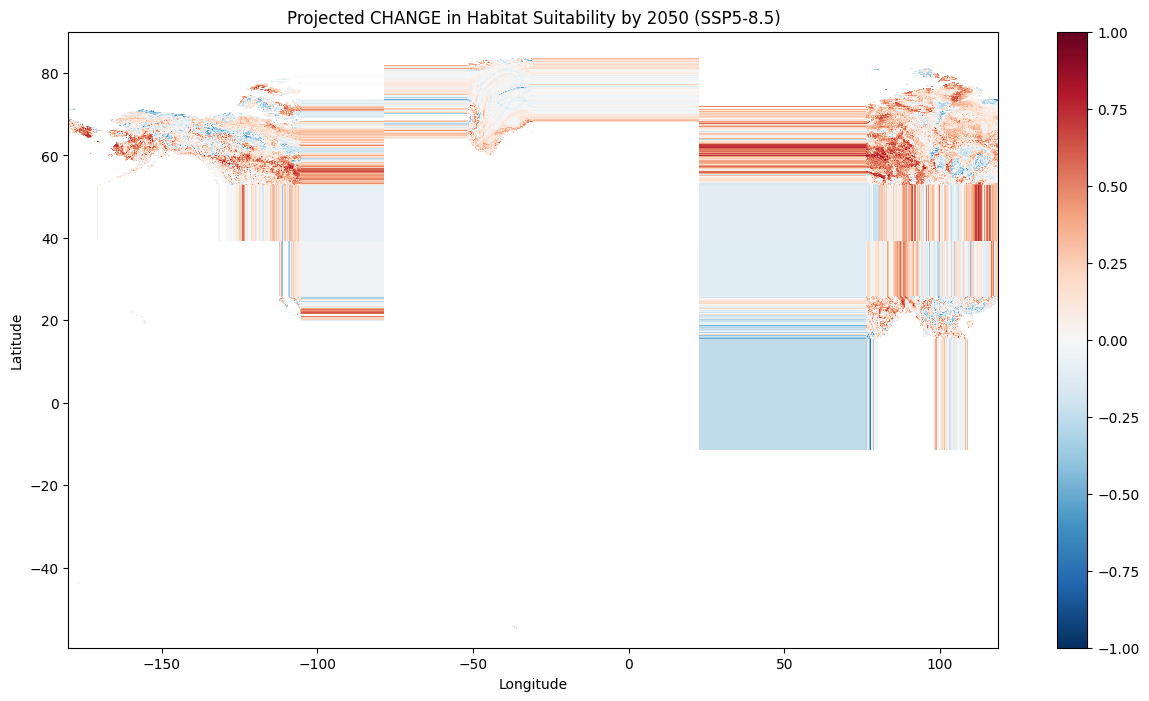

In [ ]:
# 11: Analyze and Visualize Change

print("Calculating change maps...")

# # --- Load the saved projection maps ---
# current_map = rioxarray.open_rasterio(current_map_path)
# ssp245_map = rioxarray.open_rasterio(future_ssp245_map_path)
# ssp585_map = rioxarray.open_rasterio(future_ssp585_map_path)

# The maps are already loaded from the cell above, so we can proceed

# --- Calculate Change (Future - Current) ---
change_ssp245 = ssp245_map - current_map
change_ssp585 = ssp585_map - current_map

# --- Save the change maps ---
change_ssp245_path = os.path.join(output_dir, 'change_map_ssp245.tif')
change_ssp585_path = os.path.join(output_dir, 'change_map_ssp585.tif')

change_ssp245.rio.to_raster(change_ssp245_path, tiled=True, compress='LZW')
change_ssp585.rio.to_raster(change_ssp585_path, tiled=True, compress='LZW')

print("Change maps created and saved.")

# --- Visualize the SSP5-8.5 change map in Colab for a preview ---
plt.figure(figsize=(15, 8))
change_ssp585.plot(cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Projected CHANGE in Habitat Suitability by 2050 (SSP5-8.5)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

###### **Important Note on Visualization:** Why the Preview is "Not Proper"
As observed, the preview plot generated above by Python appears fragmented and incomplete. This is not an error in the data. It is a limitation of the simple plotting tools in `matplotlib` and `xarray`, which are not designed to be full-featured GIS programs. They are excellent for quick previews, but they struggle to correctly render massive, global datasets that have large areas of `NoData` which caused alot of errors util no data parts were scrapped upon subtracting to get the change map, which caused the map to deform.